In [1]:
import numpy as np
import xarray as xr
import pandas as pd

In [2]:
colnames1 = ['DateTime','latitude','longitude', 'wind_speed']

latitudes = [i * 0.1 for i in list(range(474, 549, 1))]
longitudes = [i * 0.1 for i in list(range(58, 150, 1))]

df_latitudes, df_longitudes = [],[]
for lat in latitudes:
    df_latitudes.append([lat]*len(longitudes))
    df_longitudes.append(longitudes)
df_latitudes = np.array(df_latitudes).flatten()
df_longitudes = np.array(df_longitudes).flatten()

dates = pd.read_excel('dates.xlsx', header=None)
dtime = pd.to_datetime(dates.values)

df_dates = []
for date in dtime:
    df_dates.append([date[0]]*len(df_longitudes))
    
df_dates = np.array(df_dates).flatten()
df_latitudes = np.array([df_latitudes]*len(dtime)).flatten()
df_longitudes = np.array([df_longitudes]*len(dtime)).flatten()

df_trajectory=pd.read_excel('trajectory.xlsx', header=0)
df_trajectory['time'].apply(pd.to_datetime)

max_speed = 60
max_radius = 2
df_wspeed = []
for time in dtime:
    t_lon = df_trajectory.loc[df_trajectory['time'] == time[0], 'lon'].iloc[0]
    t_lat = df_trajectory.loc[df_trajectory['time'] == time[0], 'lat'].iloc[0]
    intensity = max_speed*df_trajectory.loc[df_trajectory['time'] == time[0], 'intensity'].iloc[0]
    radius = max_radius*df_trajectory.loc[df_trajectory['time'] == time[0], 'radius'].iloc[0]
    for lat in latitudes:
        for lon in longitudes:
            dist = (lon - t_lon)**2 + (lat - t_lat)**2
            if dist == 0:
                df_wspeed.append(intensity)
            elif dist <= radius**2:
                df_wspeed.append(intensity*(1-(dist/radius**2)))
            else:
                df_wspeed.append(0)

df = pd.DataFrame(list(zip(df_dates, df_latitudes, df_longitudes, df_wspeed)),
                  columns  =colnames1)

In [3]:
df

,DateTime,latitude,longitude,wind_speed
0,2022-04-01 01:00:00.000,47.4,5.8,3.810
1,2022-04-01 01:00:00.000,47.4,5.9,4.125
2,2022-04-01 01:00:00.000,47.4,6.0,4.410
3,2022-04-01 01:00:00.000,47.4,6.1,4.665
4,2022-04-01 01:00:00.000,47.4,6.2,4.890
...,...,...,...,...
331195,2022-04-02 23:59:59.910,54.8,14.5,0.000
331196,2022-04-02 23:59:59.910,54.8,14.6,0.000
331197,2022-04-02 23:59:59.910,54.8,14.7,0.000
331198,2022-04-02 23:59:59.910,54.8,14.8,0.000


In [4]:
# create xray Dataset from Pandas DataFrame
xr1 = df.set_index(['DateTime', 'latitude', 'longitude']).to_xarray()
xr1['latitude'].attrs={'units':'degrees', 'long_name':'Latitude'}
xr1['longitude'].attrs={'units':'degrees', 'long_name':'Longitude'}
xr1['wind_speed'].attrs={'units':'m/s', 'long_name':'wind speed'}
xr1.attrs={'Conventions':'CF-1.6', 'title':'Sythetic storm', 'summary':'Wind speed data'}

# save to netCDF
fn = 'sythetic_data.nc'
xr1.to_netcdf(fn)

In [5]:
import netCDF4 as nc
import matplotlib.pyplot as plt

In [6]:
ds = nc.Dataset(fn)

In [7]:
ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.6
    title: Sythetic storm
    summary: Wind speed data
    dimensions(sizes): DateTime(48), latitude(75), longitude(92)
    variables(dimensions): int64 DateTime(DateTime), float64 latitude(latitude), float64 longitude(longitude), float64 wind_speed(DateTime, latitude, longitude)
    groups: 

<ipython-input-9-bd77bdc26a1e>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c_scheme = mp.pcolor(x,y,np.squeeze(ws[20,:,:]),cmap = 'jet') # [0,:,:] is for the first day of the year


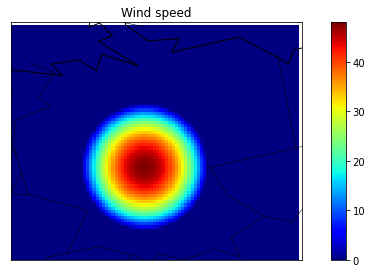

In [9]:
ws = ds['wind_speed'][:]
lon = ds['longitude'][:]
lat = ds['latitude'][:]
time = ds['DateTime'][:]

time_var = ds.variables['DateTime']
dtime = nc.num2date(time_var[:],time_var.units)

from mpl_toolkits.basemap import Basemap
mp = Basemap(llcrnrlon=5.8,   # lower longitude
             llcrnrlat=47.4,    # lower latitude
             urcrnrlon=15.0,   # uppper longitude
             urcrnrlat=54.9)

# Here you can plot the intensity over the map for a specific time
long, lats = np.meshgrid(lon,lat)  #this converts coordinates into 2D arrray
x,y = mp(long, lats) #mapping them together 
plt.figure(figsize=(6,8)) #figure size 
c_scheme = mp.pcolor(x,y,np.squeeze(ws[20,:,:]),cmap = 'jet') # [0,:,:] is for the first day of the year

# consider this as the outline for the map that is to be created 
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()

cbar = mp.colorbar(c_scheme,location='right',pad = '10%') # map information
plt.title('Wind speed')
plt.show()

#plt.savefig('tave.jpg',dpi=300) #saves the image generated